# v4.1  of ParamGen notebook
## v2.0
Adjustment in typical_range & full_range based on preliminary NSE analysis
Adjustment in stratified_sampling_for_dependent_param(args)->constrained_sample(args): logics to add more randomness
Setting of constrained_sample(args): constraint multipliers are adjusted to cover parameter space a bit better
Targetting 1,000 ~ 5,000 parameter-sets
## v3.0
1. Sobol version, as LHS is slacking.
## v4.0 & v4.1
Dependent parameter high value problem
## v5.0
Kf_fast and Kf_slow is separeted.
Added preferred range.
## v6.0 & v6.1
Beta is separated and constrained.
Better params range.
## v7
Better params range
Adding capilary rise (capW) and percolation (percH, percP) parameters.

In [1]:
import numpy as np
from scipy.stats import norm
import os

#from pyDOE import lhs

In [9]:
parameter_names = ['beta_W', 'beta_P', 'beta_H', 'D_H', 'D_P', 'KfW', 'KfaP', 'KfH', 'KfP', 'Sumax_W', 'Sumax_H', 'Sumax_P', 'TfW', 'Tfa', 'TfH', 'TfP', 'capW', 'perc']

full_range = {
    'beta_W': {'min': 0.001, 'max': 4},
    'beta_H': {'min': 0.001, 'max': 5},
    'beta_P': {'min': 0.001, 'max': 4.5},
    'D_H': {'min': 0.05, 'max': 1},
    'D_P': {'min': 0.1, 'max': 1},
    'KfW': {'min': 0.04, 'max': 1}, # allowing it to be very fast, as we are looking into smaller watersheds after all.
    'KfaP': {'min': 0.04, 'max': 1}, # Lower and upper limit constrained by KfW (0.5 * KfW <= KfaP <= KfW). Placeholder default values.
    'KfH': {'min': 0.005, 'max': 0.25}, # Lower limit constrained by KfP. Upper limit can be also constrained by KfaP. Placeholder default values.
    'KfP': {'min': 0.002, 'max': 0.02},
    'Sumax_W': {'min': 35, 'max': 500},
    'Sumax_H': {'min': 50, 'max': 750},
    'Sumax_P': {'min': 50, 'max': 1000},
    'TfW': {'min': 0, 'max': 1},
    'Tfa': {'min': 0, 'max': 1},
    'TfH': {'min': 2, 'max': 3},
    'TfP': {'min': 2, 'max': 5},
    'capW': {'min': 0.0004, 'max': 0.15},
    'perc': {'min': 0.0008, 'max': 0.1},
}

preferred_range = {
    'beta_W': {'min': 0.001, 'max': 1},
    'beta_H': {'min': 0.001, 'max': 1.96},
    'beta_P': {'min': 0.001, 'max': 1.4},
    'D_H': {'min': 0.1, 'max': 0.6},
    'D_P': {'min': 0.2, 'max': 0.8},
    #'KfW': {'min': 0.25, 'max': 0.5}, # allowing it to be very fast, as we are looking into smaller watersheds after all.
    #'KfaP': {'min': 0.25, 'max': 0.5}, # Lower and upper limit constrained by KfW (0.5 * KfW <= KfaP <= KfW). Placeholder default values.
    #'KfH': {'min': 0.04, 'max': 0.12}, # Lower limit constrained by KfP. Upper limit can be also constrained by KfaP. Placeholder default values.
    #'KfP': {'min': 0.002, 'max': 0.02},
    'KfW': {'min': 0.1, 'max': 1}, # allowing it to be very fast, as we are looking into smaller watersheds after all.
    'KfaP': {'min': 0.1, 'max': 1}, # Lower and upper limit constrained by KfW (0.5 * KfW <= KfaP <= KfW). Placeholder default values.
    'KfH': {'min': 0.005, 'max': 0.25}, # Lower limit constrained by KfP. Upper limit can be also constrained by KfaP. Placeholder default values.
    'KfP': {'min': 0.002, 'max': 0.02},
    'Sumax_W': {'min': 35, 'max': 300},
    'Sumax_H': {'min': 50, 'max': 450},
    'Sumax_P': {'min': 50, 'max': 600},
    'TfW': {'min': 0, 'max': 1},
    'Tfa': {'min': 0, 'max': 1},
    'TfH': {'min': 2, 'max': 3},
    'TfP': {'min': 2, 'max': 5},
    'capW': {'min': 0.0004, 'max': 0.15},
    'perc': {'min': 0.0008, 'max': 0.03},
}


# There was no point of setting typical range.
BetaLimit_range = {
    'beta_W': {'min': 0.001, 'max': 0.5},
    'beta_H': {'min': 0.001, 'max': 0.98},
    'beta_P': {'min': 0.001, 'max': 0.7},
    'D_H': {'min': 0.1, 'max': 0.6},
    'D_P': {'min': 0.2, 'max': 0.8},
    'KfW': {'min': 0.1, 'max': 1}, # allowing it to be very fast, as we are looking into smaller watersheds after all.
    'KfaP': {'min': 0.1, 'max': 1}, # Lower and upper limit constrained by KfW (0.5 * KfW <= KfaP <= KfW). Placeholder default values.
    'KfH': {'min': 0.005, 'max': 0.25}, # Lower limit constrained by KfP. Upper limit can be also constrained by KfaP. Placeholder default values.
    'KfP': {'min': 0.002, 'max': 0.02},
    'Sumax_W': {'min': 35, 'max': 500},
    'Sumax_H': {'min': 50, 'max': 750},
    'Sumax_P': {'min': 50, 'max': 1000},
    'TfW': {'min': 0, 'max': 1},
    'Tfa': {'min': 0, 'max': 1},
    'TfH': {'min': 2, 'max': 3},
    'TfP': {'min': 2, 'max': 5},
    'capW': {'min': 0.0004, 'max': 0.15},
    'perc': {'min': 0.0008, 'max': 0.03},
}

# Sobol

In [10]:
import numpy as np
from scipy.stats import qmc

def sigmoid(x, a=1, c=1):
    return 1 / (1 + np.exp(-a * (x - c)))

def joint_sobol_sampling(param_ranges, num_samples, decimals=4):
    """Generates Sobol samples for multiple parameters jointly."""
    num_params = len(param_ranges)
    sampler = qmc.Sobol(d=num_params, scramble=True)
    sobol_samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = {}

    # Initialize samples dictionary with arrays
    for param in param_ranges:
        samples[param] = np.zeros(num_samples)

    # Generate independent parameter samples first
    independent_params = ['beta_W', 'D_P', 'KfW', 'KfP', 'Sumax_W', 'TfW', 'capW', 'perc']
    for i, param in enumerate(independent_params):
        bounds = param_ranges[param]
        scaled_samples = sobol_samples[:, i] * (bounds['max'] - bounds['min']) + bounds['min']
        if param in ['TfW']:
            scaled_samples = np.round(scaled_samples).astype(int)
            scaled_samples = np.clip(scaled_samples, bounds['min'], bounds['max'])
        samples[param] = np.round(scaled_samples, decimals)

    # Now generate dependent parameter samples using the already sampled independent parameters
    dependent_order = ['beta_P', 'beta_H', 'D_H', 'KfaP', 'KfH', 'Sumax_H', 'Sumax_P', 'Tfa', 'TfH', 'TfP']
    dependent_params_indices = {
        'beta_P': len(independent_params),
        'beta_H': len(independent_params) + 1,
        'D_H': len(independent_params) + 2,
        'KfaP': len(independent_params) + 3,
        'KfH': len(independent_params) + 4,
        'Sumax_H': len(independent_params) + 5,
        'Sumax_P': len(independent_params) + 6,
        'Tfa': len(independent_params) + 7,
        'TfH': len(independent_params) + 8,
        'TfP': len(independent_params) + 9,
    }

    for param in dependent_order:
        dep_index = dependent_params_indices[param]
        bounds = param_ranges[param]
        if param == 'beta_P':
            min_vals = np.maximum(samples['beta_W'], bounds['min'])
            multiplier = 1.5 - 0.25 * sigmoid(samples['beta_W'], a=5, c=1)
            max_vals = np.minimum(samples['beta_W'] * multiplier, bounds['max'])
            if np.any(max_vals > 4.5):
                max_vals = 4.5
        elif param == 'beta_H':
            min_vals = np.maximum(samples['beta_P'], bounds['min'])
            multiplier = 1.5 - 0.25 * sigmoid(samples['beta_P'], a=5, c=1)
            max_vals = np.minimum(samples['beta_P'] * multiplier, bounds['max'])
            #if np.any(max_vals > 5):
             #   max_vals = 5
        elif param == 'D_H':
            min_vals = np.maximum(samples['D_P'] * 0.25, bounds['min'])
            max_vals = np.minimum(samples['D_P'], bounds['max'])
        elif param == 'KfaP':
            min_vals = np.maximum(samples['KfW'] * 0.75, bounds['min'])
            max_vals = np.minimum(samples['KfW'], bounds['max'])
        elif param == 'KfH':
            min_vals = np.maximum(samples['KfP'], bounds['min'])
            max_vals = np.minimum(samples['KfaP'] * 0.5, bounds['max'])
        elif param == 'Sumax_H':
            min_vals = np.maximum(samples['Sumax_W'], bounds['min'])
            max_vals = np.minimum(samples['Sumax_W'] * 2, bounds['max'])
        elif param == 'Sumax_P':
            min_vals = np.maximum(samples['Sumax_H'], bounds['min'])
            max_vals = np.minimum(samples['Sumax_H'] * 2, bounds['max'])
        elif param == 'Tfa':
            min_vals = bounds['min']
            max_vals = bounds['max']
        elif param == 'TfH':
            min_vals = bounds['min']
            max_vals = bounds['max']
        elif param == 'TfP':
            min_vals = bounds['min']
            max_vals = bounds['max']
            
            # Scale the Sobol samples within the updated bounds
        scaled_samples = sobol_samples[:, dep_index] * (max_vals - min_vals) + min_vals

        if param in ['Tfa', 'TfH', 'TfP']:
            scaled_samples = np.round(scaled_samples).astype(int)
            scaled_samples = np.clip(scaled_samples, bounds['min'], bounds['max'])

            if param == 'Tfa':
                scaled_samples = np.maximum(scaled_samples, samples['TfW'])
            elif param == 'TfH':
                scaled_samples = np.maximum(scaled_samples, samples['Tfa'])
            elif param == 'TfP':
                scaled_samples = np.maximum(scaled_samples, samples['TfH'])
        
            #scaled_samples = sobol_samples[:, dep_index % num_samples] * (max_vals - min_vals) + min_vals
        samples[param] = np.round(scaled_samples, decimals)

    return samples

# Beta constraining
Model performance declines noticeably when beta value exceeds 4.5

In [4]:
###Last charm>?
import numpy as np
import copy

def generate_samples_with_constraints(param_ranges_in, num_samples, threshold, max_percentage, decimals):
    """Generates samples ensuring the constraints on exceedance percentage."""
    param_ranges = copy.deepcopy(param_ranges_in)
    exceedance_limit = int(num_samples * max_percentage / 100)
    samples_accumulated = {param: [] for param in param_ranges}
    total_collected = 0
    total_exceeding = 0

    initial_max_beta_W = param_ranges['beta_W']['max']
    initial_max_beta_H = param_ranges['beta_H']['max']

    while total_collected < num_samples:
        remaining_samples = num_samples - total_collected
        samples = joint_sobol_sampling(param_ranges, remaining_samples, decimals)

        num_generated_samples = len(samples['beta_W'])

        # Calculate the number of exceedances for beta_W and beta_H
        beta_W_exceeding = np.sum(np.array(samples['beta_W']) > threshold)
        beta_H_exceeding = np.sum(np.array(samples['beta_H']) > threshold * 1.25)
        combined_exceeding = beta_W_exceeding + beta_H_exceeding

        if total_exceeding + combined_exceeding <= exceedance_limit:
            # Collect all samples
            for param in param_ranges:
                samples_accumulated[param].extend(samples[param])
            total_collected += num_generated_samples
            total_exceeding += combined_exceeding
        else:
            # Selectively accept samples to keep exceedance under limit
            for i in range(num_generated_samples):
                if total_exceeding < exceedance_limit:
                    if (samples['beta_W'][i] > threshold or samples['beta_H'][i] > threshold):
                        if (samples['beta_W'][i] > threshold and samples['beta_H'][i] > threshold * 1.25):
                            # If both exceed, count twice
                            # No let's just count once instead.
                            if total_exceeding + 1 <= exceedance_limit:
                                for param in param_ranges:
                                    samples_accumulated[param].append(samples[param][i])
                                total_collected += 1
                                total_exceeding += 1
                        else:
                            # If only one exceeds
                            for param in param_ranges:
                                samples_accumulated[param].append(samples[param][i])
                            total_collected += 1
                            total_exceeding += 1
                    else:
                        for param in param_ranges:
                            samples_accumulated[param].append(samples[param][i])
                        total_collected += 1
                else:
                    if samples['beta_W'][i] <= threshold and samples['beta_H'][i] <= threshold * 1.25:
                        for param in param_ranges:
                            samples_accumulated[param].append(samples[param][i])
                        total_collected += 1

            # Gradually narrow parameter ranges dynamically
            if beta_W_exceeding + len(samples_accumulated['beta_W']) > exceedance_limit:
                current_max_beta_W = param_ranges['beta_W']['max']
                param_ranges['beta_W']['max'] = max(threshold, current_max_beta_W - 0.1 * (current_max_beta_W - threshold))
            if beta_H_exceeding + len(samples_accumulated['beta_H']) > exceedance_limit:
                current_max_beta_H = param_ranges['beta_H']['max']
                param_ranges['beta_H']['max'] = max(threshold, current_max_beta_H - 0.1 * (current_max_beta_H - threshold * 1.25))

    # Ensure all lists are exactly num_samples in length
    for param in samples_accumulated:
        samples_accumulated[param] = np.array(samples_accumulated[param][:num_samples])

    return samples_accumulated


## Wrapper for easy use

In [5]:
def generate_custom_samples(param_ranges, num_samples, decimals=4):
    """Generates samples considering direct relationships between parameters."""
    #independent_params = ['beta_W', 'D_H', 'KfW', 'KfP', 'Sumax_W']
    #independent_ranges = {param: param_ranges[param] for param in independent_params}
    # Generate joint Sobol samples for independent parameters with constraints
    threshold = 2.5
    max_percentage = 25
    samples = generate_samples_with_constraints(param_ranges, num_samples, threshold, max_percentage, decimals)
    #samples = joint_sobol_sampling(param_ranges, num_samples)

    samples['beta_W'] = samples['beta_W'].round(3)
    samples['beta_H'] = samples['beta_H'].round(3)
    samples['beta_P'] = samples['beta_P'].round(3)
    samples['D_H'] = samples['D_H'].round(3)
    samples['D_P'] = samples['D_P'].round(3)
    samples['KfW'] = samples['KfW'].round(3)
    samples['KfaP'] = samples['KfaP'].round(3)
    samples['KfH'] = samples['KfH'].round(4)
    samples['KfP'] = samples['KfP'].round(4)
    samples['Sumax_W'] = samples['Sumax_W'].round(0)
    samples['Sumax_H'] = samples['Sumax_H'].round(0)
    samples['Sumax_P'] = samples['Sumax_P'].round(0)
    samples['TfW'] = samples['TfW'].round(0)
    samples['Tfa'] = samples['Tfa'].round(0)
    samples['TfH'] = samples['TfH'].round(0)
    samples['TfP'] = samples['TfP'].round(0)
    samples['capW'] = samples['capW'].round(4)
    samples['perc'] = samples['perc'].round(4)

    ordered_samples = [{param: samples[param][i] for param in param_ranges} for i in range(num_samples)]
    return ordered_samples

# Test the defined functions

In [34]:
test = joint_sobol_sampling(full_range, 500)
test_df =  pd.DataFrame(test)
print(test_df.tail())

     beta_W  beta_H  beta_P    D_H    D_P    KfW   KfaP    KfH    KfP  \
251   4.654   4.902   4.876  0.440  0.749  0.453  0.411  0.180  0.003   
252   4.084   4.995   4.943  0.347  0.355  0.184  0.143  0.008  0.005   
253   1.356   1.574   1.526  0.348  0.637  0.749  0.673  0.169  0.014   
254   0.051   0.070   0.054  0.119  0.169  0.411  0.397  0.189  0.007   
255   2.935   4.228   3.756  0.593  0.786  0.972  0.815  0.095  0.017   

     Sumax_W  Sumax_HP  
251  480.099   692.028  
252  436.770   838.567  
253  265.955   394.340  
254   65.261    73.735  
255  359.669   871.596  


# Define some functions for evaluation

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_parameter_distributions(samples, parameter_names):
    """
    Plots the distribution of each parameter using histograms.

    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to plot.
    """
    num_params = len(parameter_names)
    fig, axes = plt.subplots(num_params, 1, figsize=(10, 5 * num_params))
    
    if num_params == 1:
        axes = [axes]  # Make it iterable
    
    for ax, param in zip(axes, parameter_names):
        param_values = [sample[param] for sample in samples]
        ax.hist(param_values, bins=20, alpha=0.5, color='blue', density=True) #density = True?
        ax.set_title(f'Distribution of {param}')
        ax.set_xlabel(param)
        ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()


def calculate_coefficient_of_variation(samples, parameter_names):
    """
    Calculates and prints the Coefficient of Variation (CV) for each parameter.
    
    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to calculate CV for.
    """
    for param in parameter_names:
        param_values = np.array([sample[param] for sample in samples])
        mean = np.mean(param_values)
        std_dev = np.std(param_values)
        cv = std_dev / mean if mean else 0  # Avoid division by zero
        print(f'Coefficient of Variation for {param}: {cv:.3f}')

# Actual sample generation

In [11]:
import pandas as pd

#n_total = 1000
#n_full = int(n_total * 0.6)
#n_preferred = int(n_total * 0.35)
#n_KfLimit = int(n_total * 0.05)

n_full = 512
n_preferred = 256
n_BetaLimit = 256

# Generate custom samples
print(n_full, n_preferred, n_BetaLimit)

np.random.seed(827)
full_custom_samples = generate_custom_samples(full_range, n_full)
#KfLimit_custom_samples = generate_custom_samples(KfLimit_range, n_KfLimit)
BetaLimit_custom_samples = generate_custom_samples(BetaLimit_range, n_BetaLimit)
preferred_custom_samples = generate_custom_samples(preferred_range, n_preferred)
#typical_custom_samples = generate_custom_samples(typical_range, n_typical)

combined_samples = full_custom_samples + preferred_custom_samples + BetaLimit_custom_samples#+ typical_custom_samples
combined_samples_df =  pd.DataFrame(combined_samples)
print(combined_samples_df.tail())

512 256 256
      beta_W  beta_H  beta_P    D_H    D_P    KfW   KfaP     KfH     KfP  \
1019   0.363   0.606   0.492  0.444  0.739  0.832  0.784  0.1835  0.0196   
1020   0.281   0.483   0.343  0.254  0.484  0.603  0.587  0.0621  0.0159   
1021   0.193   0.262   0.247  0.413  0.650  0.132  0.102  0.0316  0.0052   
1022   0.084   0.139   0.120  0.204  0.232  0.957  0.826  0.0838  0.0120   
1023   0.390   0.564   0.436  0.169  0.624  0.508  0.447  0.2077  0.0091   

      Sumax_W  Sumax_H  Sumax_P  TfW  Tfa  TfH  TfP    capW    perc  
1019    135.0    234.0    241.0    0    1    3    4  0.0495  0.0023  
1020     78.0    154.0    178.0    0    1    3    4  0.1427  0.0284  
1021    451.0    570.0    987.0    1    1    2    3  0.0696  0.0075  
1022    371.0    574.0    804.0    1    1    2    5  0.0891  0.0094  
1023    170.0    186.0    247.0    0    0    3    3  0.0115  0.0158  


Coefficient of Variation for beta_W: 0.980
Coefficient of Variation for beta_P: 0.943
Coefficient of Variation for beta_H: 0.907
Coefficient of Variation for D_H: 0.542
Coefficient of Variation for D_P: 0.424
Coefficient of Variation for KfW: 0.503
Coefficient of Variation for KfaP: 0.511
Coefficient of Variation for KfH: 0.664
Coefficient of Variation for KfP: 0.474
Coefficient of Variation for Sumax_W: 0.533
Coefficient of Variation for Sumax_H: 0.533
Coefficient of Variation for Sumax_P: 0.515
Coefficient of Variation for TfW: 1.002
Coefficient of Variation for Tfa: 0.577
Coefficient of Variation for TfH: 0.200
Coefficient of Variation for TfP: 0.241
Coefficient of Variation for capW: 0.575
Coefficient of Variation for perc: 0.836


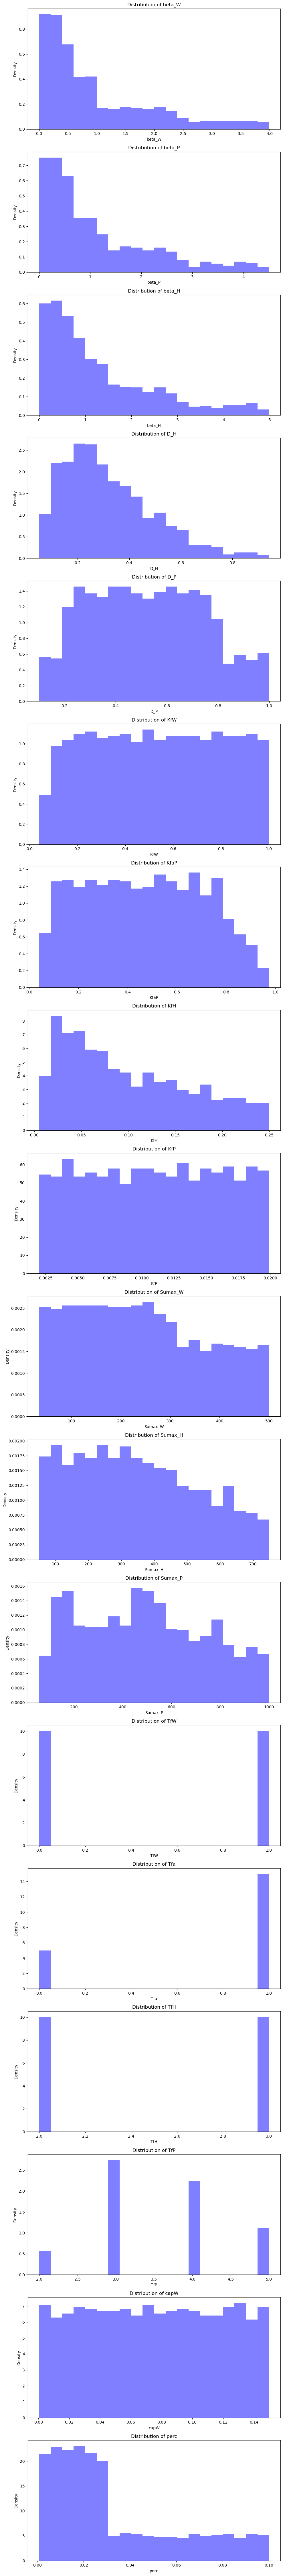

In [12]:
calculate_coefficient_of_variation(combined_samples, parameter_names)
plot_parameter_distributions(combined_samples, parameter_names)

# save the final outputs

In [13]:
df = pd.DataFrame(combined_samples)

os.chdir(os.path.join("D:\\", "wflow_models"))
from datetime import date

df.to_csv(str('combined_samples_'+ date.today().strftime("%m%d") + '.csv'), index=False)

In [9]:
# fulton ks_values = [0.0004, 0.001, 0.013]
# fulton final Ks = 0.0008

# san diego ks_values = [0.0004, 0.0006, 0.007]
# san diego final Ks = 0.0002

#ks_values = [0.0008]
df = pd.DataFrame(combined_samples)

# Create an empty dataframe to hold the new rows
expanded_df = pd.DataFrame()

# Repeat each row of the original dataframe three times with different 'Ks' values
for ks in ks_values:
    temp_df = df.copy()
    temp_df['Ks'] = ks
    expanded_df = pd.concat([expanded_df, temp_df], ignore_index=True)

print(expanded_df.tail())

      beta_W  beta_H  beta_P    D_H    D_P    KfW   KfaP     KfH     KfP  \
1019   0.023   0.050   0.034  0.196  0.730  0.999  0.760  0.2053  0.0040   
1020   0.081   0.112   0.100  0.385  0.421  0.737  0.598  0.0952  0.0056   
1021   0.253   0.441   0.360  0.260  0.723  0.181  0.168  0.0820  0.0115   
1022   0.374   0.484   0.423  0.188  0.280  0.886  0.842  0.0632  0.0085   
1023   0.196   0.238   0.200  0.367  0.583  0.536  0.442  0.1423  0.0189   

      Sumax_W  Sumax_H  Sumax_P  TfW  Tfa  TfH  TfP    capW    perc      Ks  
1019    200.0    202.0    275.0    0    0    2    4  0.0088  0.0119  0.0004  
1020    247.0    303.0    392.0    0    0    2    4  0.0782  0.0210  0.0004  
1021     95.0    150.0    242.0    1    1    3    3  0.0251  0.0110  0.0004  
1022     81.0     94.0    169.0    1    1    3    5  0.1218  0.0048  0.0004  
1023    152.0    272.0    304.0    0    1    2    3  0.0569  0.0239  0.0004  


In [10]:
wsName_list = ["san-diego_california_20331196_11023340",
               "fulton_georgia_2047963_02336410"
              ]

#wsName = "san-diego_california_20331196_11023340"
wsName = "fulton_georgia_2047963_02336410"

os.chdir(os.path.join("D:\\", "wflow_models"))
from datetime import date

expanded_df.to_csv(str('combined_samples_'+ date.today().strftime("%m%d") + '_' + wsName + '.csv'), index=False)

# OLD

In [ ]:
import numpy as np

def sample_parameters(defaults, range_constraints):
    params = {}
    for param, stats in defaults.items():
        mean, std = stats['mean'], stats['std']
        min_val, max_val = range_constraints[param]['min'], range_constraints[param]['max']
        
        # Sample within the specified range
        while True:
            sample = np.random.normal(mean, std)
            if min_val <= sample <= max_val:
                params[param] = sample
                break
    
    # Ensure relationships between parameters
    # This may need several iterations for all conditions to be satisfied
    satisfied = False
    while not satisfied:
        if params['beta_W'] > params['beta_HP']:
            params['beta_W'], params['beta_HP'] = np.random.normal(defaults['beta_W']['mean'], defaults['beta_W']['std']), np.random.normal(defaults['beta_HP']['mean'], defaults['beta_HP']['std'])
        
        if params['D_H'] >= params['D_P']:
            params['D_H'], params['D_P'] = np.random.normal(defaults['D_H']['mean'], defaults['D_H']['std']), np.random.normal(defaults['D_P']['mean'], defaults['D_P']['std'])
        
        if params['Kf_fast'] >= params['Kf_slow']:
            params['Kf_fast'], params['Kf_slow'] = np.random.normal(defaults['Kf_fast']['mean'], defaults['Kf_fast']['std']), np.random.normal(defaults['Kf_slow']['mean'], defaults['Kf_slow']['std'])
        
        if params['Sumax_W'] > params['Sumax_HP']:
            params['Sumax_W'], params['Sumax_HP'] = np.random.normal(defaults['Sumax_W']['mean'], defaults['Sumax_W']['std']), np.random.normal(defaults['Sumax_HP']['mean'], defaults['Sumax_HP']['std'])
        
        # Check if all relationships are satisfied
        satisfied = (params['beta_W'] <= params['beta_HP'] and
                     params['D_H'] < params['D_P'] and
                     params['Kf_fast'] < params['Kf_slow'] and
                     params['Sumax_W'] <= params['Sumax_HP'])
    
    return params

# Example usage
defaults = {
    'beta_W': {'mean': 0.27, 'std': 0.135},
    'beta_HP': {'mean': 0.27, 'std': 0.135},
    'D_H': {'mean': 0.24, 'std': 0.12},
    'D_P': {'mean': 0.24, 'std': 0.12},
    'Kf_fast': {'mean': 0.04, 'std': 0.02},
    'Kf_slow': {'mean': 0.005, 'std': 0.0025},
    'Sumax_W': {'mean': 100, 'std': 50},
    'Sumax_HP': {'mean': 250, 'std': 125}
}

range_constraints = {
    'beta_W': {'min': 0, 'max': 5},
    'beta_HP': {'min': 0, 'max': 5},
    'D_H': {'min': 0, 'max': 1},
    'D_P': {'min': 0, 'max': 1},
    'Kf_fast': {'min': 0.01, 'max': 0.08},
    'Kf_slow': {'min': 0.0008, 'max': 0.01},
    'Sumax_W': {'min': 5, 'max': 250},
    'Sumax_HP': {'min': 5, 'max': 500},
}

sample


2336410


/tmp/ipykernel_15557/1625775067.py:25: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
/tmp/ipykernel_15557/1625775067.py:26: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)


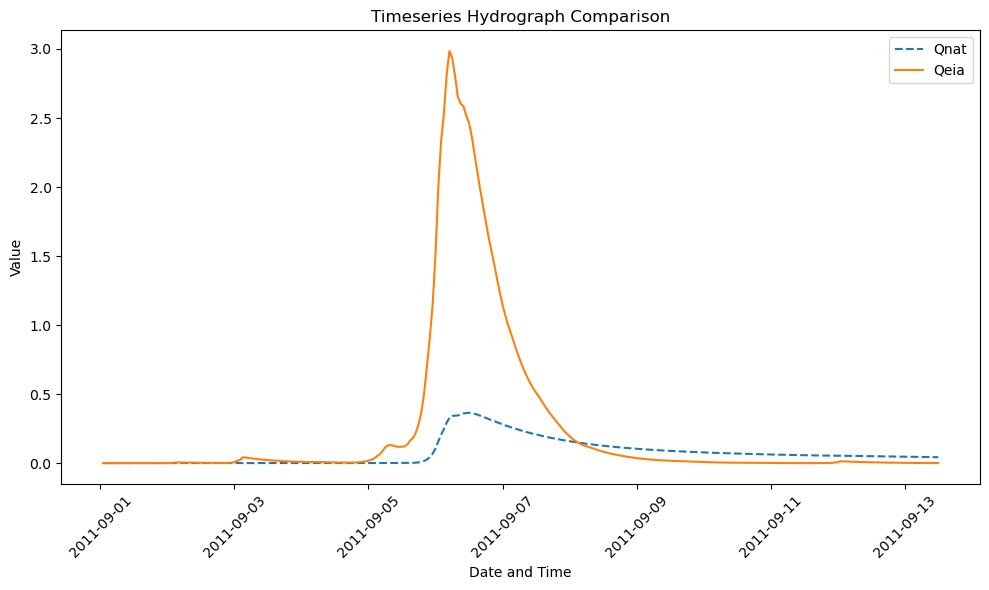

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


runId = "output/test_dt_Simp2"

outlet = str(int(wsName.split("_")[-1]))
print(outlet)

output_directory = str("../wflow_models/" +wsName + "/" + runId)

# Create a time series index
date_range = pd.date_range(start=datetimestart, periods=lastTimeStep + 1, freq=f'{timestepsecs}s')
date_range = date_range[:-1]

# Paths to the CSV files
#path0 = str(output_directory + '/Prec.csv')
path1 = str(output_directory + '/Qt.csv')
path2 = str(output_directory + '/Qeia.csv')



# Read the last column from both CSV files
df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)
#df3 = pd.read_csv(path3, usecols=['1401'], squeeze=True)
#df4 = pd.read_csv(path4, usecols=['1401'], squeeze=True)
#df5 = pd.read_csv(path5, usecols=['1401'], squeeze=True)
#df6 = pd.read_csv(path6, usecols=['1401'], squeeze=True)


# Assign the date_range as the index directly
df1.index = date_range
df2.index = date_range
#df3.index = date_range
#df4.index = date_range
#df5.index = date_range
#df6.index = date_range


# Ensure the lengths match, trimming if necessary (optional, remove if not needed)
df1 = df1.iloc[:len(date_range)]
df2 = df2.iloc[:len(date_range)]
#df3 = df3.iloc[:len(date_range)]
#df4 = df4.iloc[:len(date_range)]
#df5 = df5.iloc[:len(date_range)]
#df6 = df6.iloc[:len(date_range)]




# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df1.index, df1, label='Qnat', linestyle='--')
plt.plot(df2.index, df2, label='Qeia')
#plt.plot(df3.index, df3, label='BetaKf0Lumped', linestyle='--')
#plt.plot(df4.index, df4, label='Realistic', linestyle='--')
#plt.plot(df5.index, df5, label='None', linestyle='-.')
#plt.plot(df6.index, df6, label='BetaKf0Distributed', linestyle='-.')
plt.title('Timeseries Hydrograph Comparison')
plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm
from pyDOE import lhs

# Define the number of samples
num_samples = 1000

# LHS sampling from a uniform distribution [0, 1) for each parameter (4 parameters in total)
uniform_samples = lhs(4, samples=num_samples)

# Default values and standard deviations for Gaussian transformation
defaults = {
    'beta': {'mean': 2.55, 'std': 1.275},  # Adjust mean and std according to your needs
    'D': {'mean': 0.5, 'std': 0.25},
    'Kf': {'mean': 0.0204, 'std': 0.01},
    'Sumax': {'mean': 350, 'std': 125},
}

# Parameter constraints (example values, adjust as needed)
constraints = {
    'beta_a': {'min': 0.1, 'max': 5},
    'D_b': {'min': 0, 'max': 1},
    'Kf_c': {'min': 0.0008, 'max': 0.04},
    'Sumax_d': {'min': 100, 'max': 600},
}

# Transform uniform LHS samples to Gaussian based on default values
gaussian_samples = np.zeros(uniform_samples.shape)
for i, (key, value) in enumerate(defaults.items()):
    gaussian_samples[:, i] = norm.ppf(uniform_samples[:, i], loc=value['mean'], scale=value['std'])

# Apply constraints (simple example, more complex logic might be required for your specific model)
# Ensure samples are within defined ranges
for i, (key, constraint) in enumerate(constraints.items()):
    gaussian_samples[:, i] = np.clip(gaussian_samples[:, i], constraint['min'], constraint['max'])

# For correlated parameters, like beta, enforce a = d < b = c through sorting or other logic
# This step is highly specific to your model's constraints and might need customization

# Example: Sorting the 'beta' and 'D' samples to enforce a simple constraint
# This is a placeholder step; replace with your specific constraints logic
gaussian_samples[:, [0, 1]] = np.sort(gaussian_samples[:, [0, 1]], axis=1)

# Output
print("Sample of transformed and constrained Gaussian LHS samples for each parameter:")
for i, param in enumerate(defaults.keys()):
    print(f"{param}: {gaussian_samples[:5, i]}")
